In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess
from Bio import Phylo
from io import StringIO
import msprime
import tqdm

In [143]:
def extract_tree_sequence(tree, sample_times, sample_sizes,Ne=10000,add_neutral=False):
    
    num_times = len(sample_times)
    if num_times!=len(sample_sizes): print("Please give the same length list for sample times and sizes.")   
    
    
    # Subsample tree
    sample = [np.random.choice(pyslim.individuals_alive_at(tree,sample_times[i]), 
                               size = int(sample_sizes[i]), replace=False) for i in list(range(num_times))]
    sample = np.concatenate(sample)
    sample_nodes = [tree.individual(i).nodes[0] for i in sample]
    # Identifying the nodes of the chosen downsample individuals. 
    ts_ds = tree.simplify(samples=sample_nodes) 
    # This writes a new tree sequence with just downsampled individuals.
    
    # Double check everyone has coalesced within the time frame.
    # Recapitate if needed.
    tsf = ts_ds.first()
#     if len(tsf.roots) != 1 : 
#         print("Not everyone has coalesced within your time frame! Recapitating...")
#         ts_ds = pyslim.recapitate(ts_ds,
#                 recombination_rate=0,
#                 ancestral_Ne=Ne, random_seed=5)
#         print("Successfully recapitated")
    
    # Add neutral mutations if needed
    if add_neutral:
        next_id = pyslim.next_slim_mutation_id(ts_ds)
        ts = msprime.sim_mutations(
               ts_haploid,
               rate=1e-3,    # per bp
               model=msprime.SLiMMutationModel(type=3, next_id=next_id), # type=3 is just any mutation type unused in the simulation
               keep=True)
        print(f"We now have {ts_ds.num_mutations} deleterious mutations and {tsn.num_mutations} total mutations.")
    else:
        ts = ts_ds
    
    # Get coalescent times.
    node_times = ts.tables.nodes.time
    coal_times = node_times[sum(sample_sizes):] # the first ones are tips, so a bunch of 0s
    
    # Get mutation information.
    mutation_times = []
    mutation_edges = []
    for m in ts.mutations():
        mutation_times.append(m.metadata["mutation_list"][0]["slim_time"])
        mutation_edges.append(m.edge)
    
    return ts, coal_times, mutation_times, mutation_edges




In [39]:
trees = tskit.load(output)

In [124]:
def estimate_Ne(coal_times, grid_points, n_samples):
    coal_times = np.concatenate([[0], coal_times])
    n_coalescences = len(coal_times)
    n_lineages = np.arange(n_samples, 1, -1)[:n_coalescences-1]
    Nes = np.concatenate([np.diff(coal_times) * n_lineages * (n_lineages - 1) / 2, [np.nan]])
    xs = np.searchsorted(coal_times, grid_points, side="right")-1
    return Nes, Nes[xs]


In [112]:
len(set(coal_times)) == len(coal_times)

True

In [141]:
grid_points = np.arange(0, 20000, 100)

In [142]:
all_grids = []

sample_size = 10
reps = 10

for i in range(reps):    
    ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(trees, sample_times=[0], sample_sizes=[sample_size])
    Nes, grid_Nes = estimate_Ne(coal_times, grid_points, sample_size)
    all_grids.append(grid_Nes)



Not everyone has coalesced within your time frame! Recapitating...
Not everyone has coalesced within your time frame! Recapitating...
Not everyone has coalesced within your time frame! Recapitating...
Not everyone has coalesced within your time frame! Recapitating...
Not everyone has coalesced within your time frame! Recapitating...
Not everyone has coalesced within your time frame! Recapitating...


/tmp/ipykernel_536333/783797664.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(grid_points, np.nanmean(np.array(all_grids), axis=0))


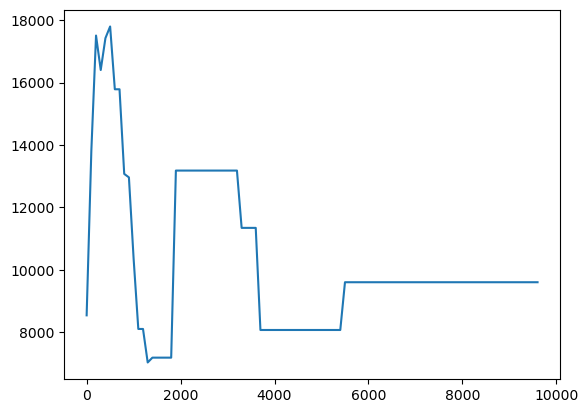

In [146]:
plt.plot(grid_points, np.nanmean(np.array(all_grids), axis=0))

## More trees

In [485]:
import glob

all_trees_filenames = sorted(glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/constant_20230420/seed=*/output.trees"))

In [486]:
def generate_grid_samples(filename, sample_size, n_reps):
    trees = tskit.load(filename)
    
    all_coals = []
    all_grids = []
    

    for i in range(n_reps):    
        ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(trees, sample_times=[0], sample_sizes=[sample_size])
        while (len(set(coal_times)) != len(coal_times)):
            print("Multiple merger, redrawing...")
            ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(trees, sample_times=[0], sample_sizes=[sample_size])
        Nes, grid_Nes = estimate_Ne(coal_times, grid_points, sample_size)
        all_coals.append(coal_times)
        all_grids.append(grid_Nes)
        
    return np.array(all_grids), all_coals


    

In [494]:
all_coals = []
all_grids = []

for fn in tqdm.tqdm(all_trees_filenames):
    ag, ac = generate_grid_samples(fn, 10, 100)
    all_grids.extend(ag)
    all_coals.extend(ac)


  5%|████▉                                                                                              | 5/100 [02:43<51:43, 32.67s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


  8%|███████▉                                                                                           | 8/100 [03:32<32:19, 21.08s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...


 18%|█████████████████▋                                                                                | 18/100 [09:03<45:40, 33.42s/it]

Multiple merger, redrawing...


 21%|████████████████████▌                                                                             | 21/100 [10:50<46:24, 35.24s/it]

Multiple merger, redrawing...


 22%|█████████████████████▌                                                                            | 22/100 [11:25<45:49, 35.25s/it]

Multiple merger, redrawing...


 29%|████████████████████████████▍                                                                     | 29/100 [15:24<40:18, 34.07s/it]

Multiple merger, redrawing...


 34%|█████████████████████████████████▎                                                                | 34/100 [18:13<37:12, 33.82s/it]

Multiple merger, redrawing...


 38%|█████████████████████████████████████▏                                                            | 38/100 [20:28<34:49, 33.70s/it]

Multiple merger, redrawing...


 41%|████████████████████████████████████████▏                                                         | 41/100 [22:09<32:54, 33.46s/it]

Multiple merger, redrawing...


 45%|████████████████████████████████████████████                                                      | 45/100 [24:21<30:29, 33.27s/it]

Multiple merger, redrawing...


 64%|██████████████████████████████████████████████████████████████▋                                   | 64/100 [34:54<19:58, 33.29s/it]

Multiple merger, redrawing...


 67%|█████████████████████████████████████████████████████████████████▋                                | 67/100 [36:34<18:14, 33.17s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


 68%|██████████████████████████████████████████████████████████████████▋                               | 68/100 [37:09<18:05, 33.92s/it]

Multiple merger, redrawing...


 69%|███████████████████████████████████████████████████████████████████▌                              | 69/100 [37:42<17:24, 33.70s/it]

Multiple merger, redrawing...


 73%|███████████████████████████████████████████████████████████████████████▌                          | 73/100 [39:55<14:59, 33.31s/it]

Multiple merger, redrawing...


 74%|████████████████████████████████████████████████████████████████████████▌                         | 74/100 [40:04<11:14, 25.95s/it]

Multiple merger, redrawing...


 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 80/100 [43:25<10:51, 32.59s/it]

Multiple merger, redrawing...


 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 82/100 [44:32<09:56, 33.13s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 84/100 [45:42<09:01, 33.84s/it]

Multiple merger, redrawing...


 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 85/100 [46:16<08:28, 33.88s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 86/100 [46:50<07:57, 34.10s/it]

Multiple merger, redrawing...


 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 87/100 [47:25<07:26, 34.33s/it]

Multiple merger, redrawing...


 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 89/100 [48:32<06:12, 33.88s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 91/100 [49:47<05:18, 35.39s/it]

Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...
Multiple merger, redrawing...


 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [50:22<04:41, 35.24s/it]

Multiple merger, redrawing...


 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 94/100 [51:30<03:27, 34.62s/it]

Multiple merger, redrawing...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:50<00:00, 32.91s/it]


In [359]:
import collections

In [373]:
def new_and_better_estimate_Ne(coal_times, n_samples, grid_points):
    coal_times = np.concatenate([[0], coal_times])
    gammas = np.diff(coal_times)
    factors = np.arange(n_samples, 0, -1)[:len(gammas)]
    factors = factors * (factors-1)/2
    Ne_estimates = gammas * factors

    Ne_estimates_with_nan = np.concatenate([Ne_estimates, [np.nan]])
    
    temp = np.searchsorted(coal_times, grid_points, side="right")-1
    d = collections.Counter(temp)
    a = []
    for i in range(len(d)):
        a.append([Ne_estimates_with_nan[i]]*d[i])

    return Ne_estimates, np.concatenate(a)
 
grid_points = np.sort(np.concatenate(all_coals))

xxx = [new_and_better_estimate_Ne(coal_times, 10, grid_points) for coal_times in all_coals]
#eee = [new_and_better_estimate_Ne(coal_times, 10, grid_points) for coal_times in all_coals]
# for coal_times, Ne_estimates in zip(all_coals, eee):
#     plt.stairs(Ne_estimates, np.concatenate([[0], coal_times]), color="blue", alpha=0.1)

In [374]:
np.nanmean(np.concatenate([x[0] for x in xxx]))

5384.686263614137

In [375]:
max_len = max([len(x[1]) for x in xxx])

In [376]:
Z = np.zeros((len(xxx), max_len))
Z[:,:] = np.nan
for i, x in enumerate(xxx):
    Z[i,:len(x[1])] = x[1]
    



/tmp/ipykernel_536333/3815136815.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(grid_points, 1/np.nanmean(1/Z, axis=0))


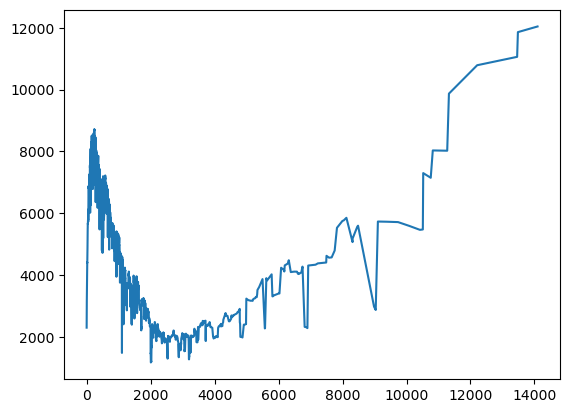

In [377]:
plt.plot(grid_points, 1/np.nanmean(1/Z, axis=0))

In [379]:
np.nanmean(1/np.nanmean(1/Z, axis=0))

/tmp/ipykernel_536333/2796092255.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(1/np.nanmean(1/Z, axis=0))


4402.707455044783

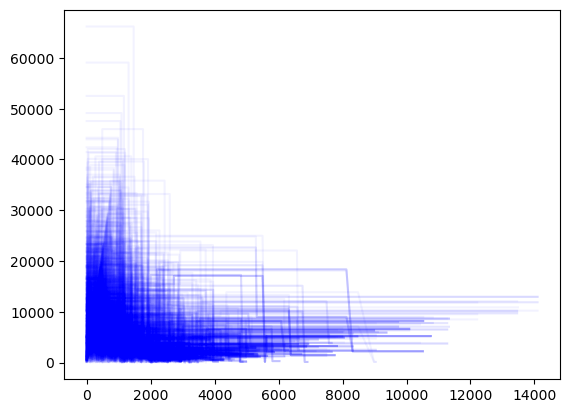

In [380]:
for x in xxx:
    plt.plot(grid_points[:len(x[1])], x[1], color="blue", alpha=0.05)

In [381]:
all_diffs = [np.diff(np.concatenate([[0], coal_times])) for coal_times in all_coals]

In [388]:
import math

for i in range(9):
    print(i, np.mean([x[i] * math.comb(10-i, 2) for x in all_diffs]))

0 9056.295
1 8565.624
2 7165.004
3 6287.652
4 4881.93
5 4199.83
6 3409.05
7 2748.768


IndexError: index 8 is out of bounds for axis 0 with size 8

## Another way

In [409]:
filename = "/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/constant_20230420/seed=0/output.trees"
trees = tskit.load(filename)
ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(trees, sample_times=[0], sample_sizes=[10000])

In [418]:
import scipy.special

def simpler_estimate_Ne(coal_times, max_generations, n_samples):
    n_lineages = np.ones(max_generations, dtype=int) * n_samples
    for coal_time in coal_times.astype(int):
        n_lineages[coal_time:] -= 1
    n_possible_pairs = scipy.special.comb(n_lineages, 2)
    n_successes = -np.diff(n_lineages)

    return n_possible_pairs[:-1], n_successes
    

n_posssible_pairs, n_successes = simpler_estimate_Ne(coal_times, 20000, 10000)

In [498]:
import glob

all_trees_filenames = sorted(glob.glob("/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/constant_20230420/seed=*/output.trees"))

In [499]:
all_n_posssible_pairs, all_n_successes = [], []

for filename in tqdm.tqdm(all_trees_filenames):
    trees = tskit.load(filename)
    ts, coal_times, mutation_times, mutation_edges = extract_tree_sequence(trees, sample_times=[0], sample_sizes=[10])
    n_posssible_pairs, n_successes = simpler_estimate_Ne(coal_times, 20000, 10)
    all_n_posssible_pairs.append(n_posssible_pairs)
    all_n_successes.append(n_successes)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


(0.0, 100.0)

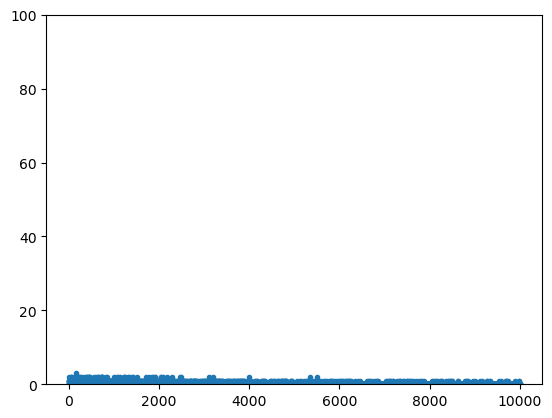

In [500]:
plt.plot(np.sum(all_n_successes, axis=0)[:10000], '.')
plt.ylim(0,100)

/tmp/ipykernel_536333/4114905959.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot((np.sum(all_n_posssible_pairs, axis=0) / np.sum(all_n_successes, axis=0))[:1000], '.')


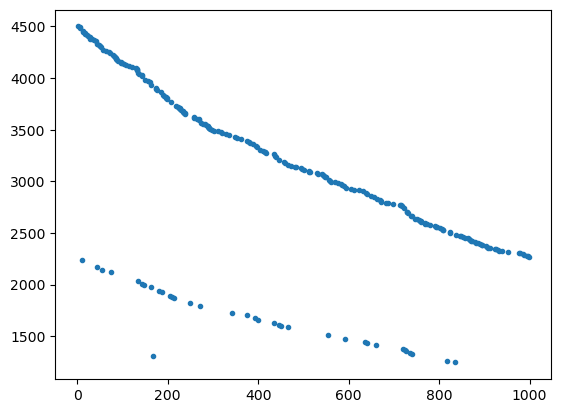

In [506]:
plt.plot((np.sum(all_n_posssible_pairs, axis=0) / np.sum(all_n_successes, axis=0))[:1000], '.')

/tmp/ipykernel_536333/2273757646.py:5: RuntimeWarning: divide by zero encountered in divide
  (np.sum(all_n_posssible_pairs, axis=0) / np.sum(all_n_successes, axis=0)),


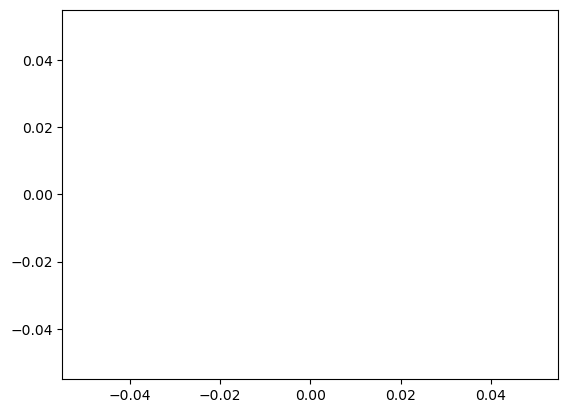

In [505]:
from scipy.ndimage import uniform_filter1d

plt.plot(
    uniform_filter1d(
        (np.sum(all_n_posssible_pairs, axis=0) / np.sum(all_n_successes, axis=0)),
        100
    ),
    '.')

/tmp/ipykernel_536333/279151551.py:5: RuntimeWarning: divide by zero encountered in divide
  1/np.mean(np.array(all_n_successes) / np.array(all_n_posssible_pairs), axis=0),


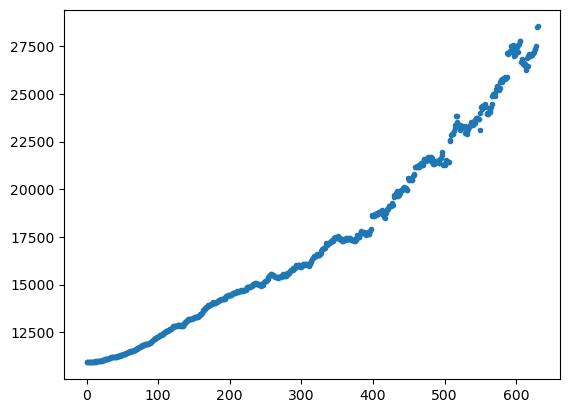

In [457]:
from scipy.ndimage import uniform_filter1d

plt.plot(
    uniform_filter1d(
        1/np.mean(np.array(all_n_successes) / np.array(all_n_posssible_pairs), axis=0),
        100
    ),
    '.')

In [438]:
1/(2609/(10000*9999/2))

19162.514373323113

In [434]:
all_n_successes[0]

array([2609, 1320,  824, ...,    0,    0,    0])

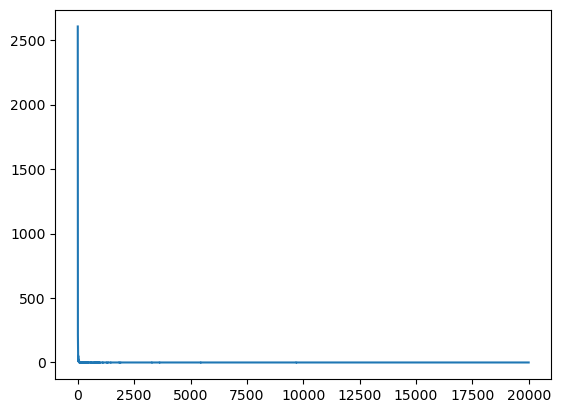

In [421]:
plt.plot(n_successes)

## Another attempt

In [481]:
def an_even_newer_and_better_estimate_Ne(all_coals, n_samples, max_generations, stride):
    Ne_estimates_grid = np.arange(0, max_generations, stride)
#     Ne_estimates_grid_num_observations = np.zeros(0, max_generations, stride)
    
#     for coal_times in all_coals:
#         coal_times_with_zero = np.concatenate([[0], coal_times])
#         gammas = np.diff(coal_times_with_zero)
#         factors = np.arange(n_samples, 0, -1)[:len(gammas)]
#         factors = factors * (factors-1)/2
#         Ne_estimates = gammas * factors
        
#         for coal_time_diff, coal_time, Ne_estimate in zip(gammas, coal_times, Ne_estimates):
#             x = coal_time - coal_time_diff/2
#             grid_index = int(x) // int(stride)
#             Ne_estimates_grid[grid_index] += Ne_estimate
#             Ne_estimates_grid_num_observations += 1
            
#     print(Ne_estimates_grid)
#     print(Ne_estimates_grid_num_observations)

    xs = []
    ys = []
    all_Ne_estimates = []
    
    for grid_point in Ne_estimates_grid:
        # [grid_point, grid_point + stride)
        
        aggregated_sum = []
        n_items = 0
        
        x_points = []
        
        for coal_times in all_coals:                        
            coal_times_with_zero = np.concatenate([[0], coal_times])            
            gammas = np.diff(coal_times_with_zero)
            factors = np.arange(n_samples, 0, -1)[:len(gammas)]
            factors = factors * (factors-1)/2
            Ne_estimates = gammas * factors
            
            all_Ne_estimates.extend(Ne_estimates)

            for coal_time_diff, coal_time, Ne_estimate in zip(gammas, coal_times, Ne_estimates):            
                if (coal_time // stride) * stride == grid_point:
                    aggregated_sum.append(Ne_estimate)
                    n_items += 1
                    x_points.append(coal_time - coal_time_diff/2)
                    
        if n_items > 0:
            x = np.mean(x_points)
            y = np.mean(aggregated_sum)

            xs.append(x)
            ys.append(y)
        
    return xs, ys, all_Ne_estimates
                    
        
                    
          
 


In [495]:
xs, ys, all_Ne_estimates = an_even_newer_and_better_estimate_Ne(all_coals, n_samples = 10, max_generations = 20000, stride = 100)

In [496]:
np.mean(all_Ne_estimates)

9853.129475504324

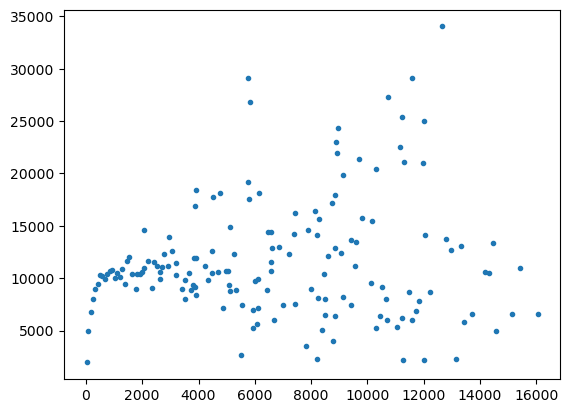

In [497]:
plt.plot(xs, ys, '.')

In [508]:
from numpy import log
from scipy.special import betaln

def binomln(n, k):
    # Assumes binom(n, k) >= 0
    return -betaln(1 + n - k, 1 + k) - log(n + 1)

def F(N, m, i): 
    return binomln(N, i) - m * log(N)

In [544]:
import scipy.optimize

m = 1000
i = 850

res = scipy.optimize.minimize(
    fun = lambda x: -F(x[0], m, i), 
    x0 = [i,],
    bounds = [(0, np.inf)],
)

print(res)
print(res.x)
    

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 6222.269265772601
        x: [ 2.993e+03]
      nit: 16
      jac: [ 0.000e+00]
     nfev: 36
     njev: 18
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
[2992.78142761]


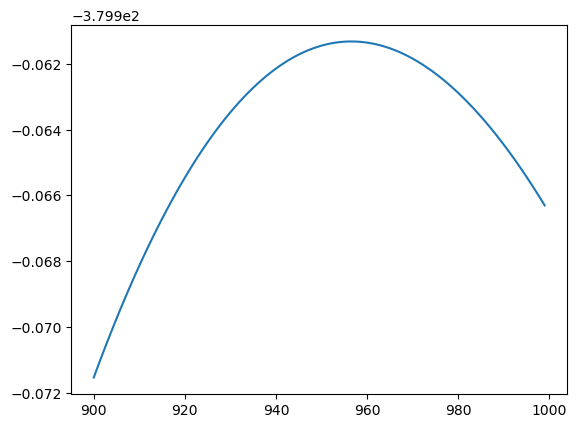

In [515]:
xs = np.arange(900, 1000)

plt.plot(xs, F(xs, 100, 95))

In [523]:
F(np.array([955, 956, 957, 958]), 100, 95)

array([-379.96133768, -379.96133152, -379.96133124, -379.96133681])